# News Recommendation System Capstone Project

iPrint being a cutting-edge company, is trying to solve this issue of revenue leakage by personalising user tastes and introducing new content to its users at the start of the day on the home page of the application. iPrint is planning to assess these recommendations by tracking whether the user clicks on those items or not. Moreover, once the user clicks on any news item A, it wants to recommend news similar to the news A, at the bottom of the page of the news item A. 


By, recommending new items to the users at the start of the day, it is trying to understand if the user has new interests or not. Now, if the user clicks on the new item A and then also on subsequent items recommended at the bottom of the news item A, then iPrint can infer that the topic/ genre of the new item is something of user interest.


Now, we have been hired as a data scientist to help iPrint build a robust product to achieve its new objectives. We need to build a system that would recommend relevant news articles to the customers based on their search history and preferences. 


So the problem statement can be divided into two parts discussed below. Of the numerous news articles available on its app about sports, politics, technology and many others, iPrint wants us as a data scientist to identify and build an appropriate recommendation system that would:

- Recommend new top 10 relevant articles to a user when he visits the app at the start of the day
- Recommend top 10 similar news articles that match the ones clicked by the user. Try different models for generating these recommendations and experiment with hybrid models for the same

We have to ensure that the system does not recommend any news article that has been pulled out from the app or has already been seen by the user. In addition, only the articles that are written in the English language must be considered for content-based recommendations. The final generated list must contain the names of the recommended articles, along with their IDs.

### Import Libraries

In [449]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



In [450]:
pd.set_option('display.max_colwidth', 200)

### Import Consumer Data

In [451]:
consumer_df=pd.read_csv("consumer_transanctions.csv")
consumer_df.head()

,event_timestamp,interaction_type,item_id,consumer_id,consumer_session_id,consumer_device_info,consumer_location,country
0,1465413032,content_watched,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NaN
1,1465412560,content_watched,8890720798209849691,-1032019229384696495,3621737643587579081,"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/52.0.2743.24 Safari/537.36",NY,US
2,1465416190,content_watched,310515487419366995,-1130272294246983140,2631864456530402479,NaN,NaN,NaN
3,1465413895,content_followed,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN
4,1465412290,content_watched,-7820640624231356730,-445337111692715325,561148 1178424124714,NaN,NaN,NaN


In [452]:
#shape of dataset
consumer_df.shape 

(72312, 8)

In [453]:
#check the data stats
consumer_df.describe() 

,event_timestamp,item_id,consumer_id
count,7.231200e+04,7.231200e+04,7.231200e+04
mean,1.470103e+09,-3.033423e+16,1.252026e+16
std,7.258130e+06,5.344755e+18,5.022333e+18
min,1.457964e+09,-9.222795e+18,-9.223122e+18
25%,1.464876e+09,-4.726309e+18,-3.596627e+18
50%,1.468343e+09,1.893099e+16,-1.088422e+17
75%,1.474461e+09,4.441012e+18,3.766319e+18
max,1.488310e+09,9.222265e+18,9.210531e+18


In [454]:
 #check the columns and info
consumer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72312 entries, 0 to 72311
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   event_timestamp       72312 non-null  int64 
 1   interaction_type      72312 non-null  object
 2   item_id               72312 non-null  int64 
 3   consumer_id           72312 non-null  int64 
 4   consumer_session_id   72312 non-null  object
 5   consumer_device_info  56918 non-null  object
 6   consumer_location     56907 non-null  object
 7   country               56918 non-null  object
dtypes: int64(3), object(5)
memory usage: 4.4+ MB


In [455]:
consumer_df['interaction_type'].value_counts()

content_watched         61086
content_liked            5745
content_saved            2463
content_commented_on     1611
content_followed         1407
Name: interaction_type, dtype: int64

#### Creating a ratings column and imputing the rating values based on the feature ‘interaction type’ with the highest weightage to content_followed, followed by content_commented_on, content saved, content liked and content_watched

In [456]:
# creating a new column for 'ratings' 
consumer_df['ratings']=consumer_df['interaction_type'].map({'content_followed':5,
                                                            'content_commented_on':4, 
                                                            'content_saved':3, 
                                                            'content_liked':2, 
                                                            'content_watched':1})

In [457]:
consumer_df.head()

,event_timestamp,interaction_type,item_id,consumer_id,consumer_session_id,consumer_device_info,consumer_location,country,ratings
0,1465413032,content_watched,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NaN,1
1,1465412560,content_watched,8890720798209849691,-1032019229384696495,3621737643587579081,"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/52.0.2743.24 Safari/537.36",NY,US,1
2,1465416190,content_watched,310515487419366995,-1130272294246983140,2631864456530402479,NaN,NaN,NaN,1
3,1465413895,content_followed,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN,5
4,1465412290,content_watched,-7820640624231356730,-445337111692715325,561148 1178424124714,NaN,NaN,NaN,1


### Exploratory data analysis

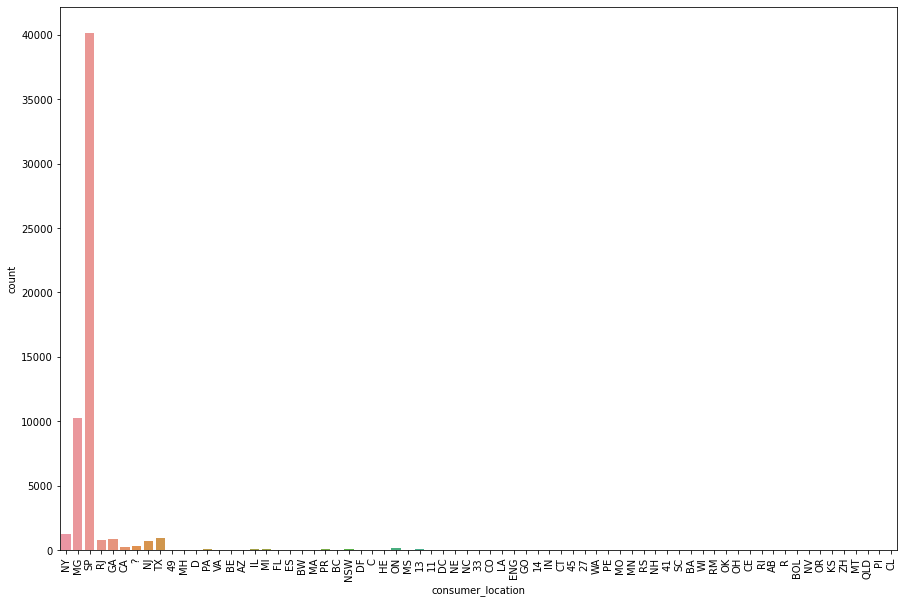

In [458]:
plt.figure(figsize=(15,10))
plt.xticks(rotation=90)
sns.countplot(x="consumer_location", data=consumer_df)

### Inference
- This shows that the consumers of these articles are located majorly in SP, MG and NY location

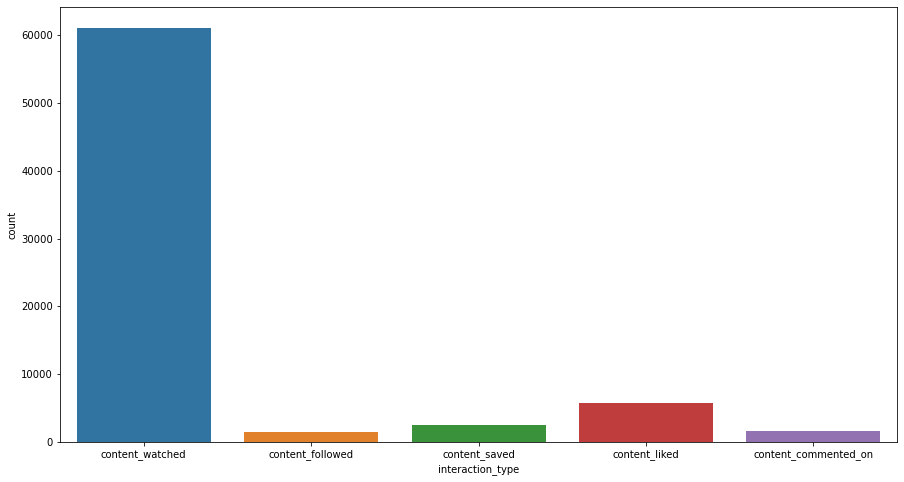

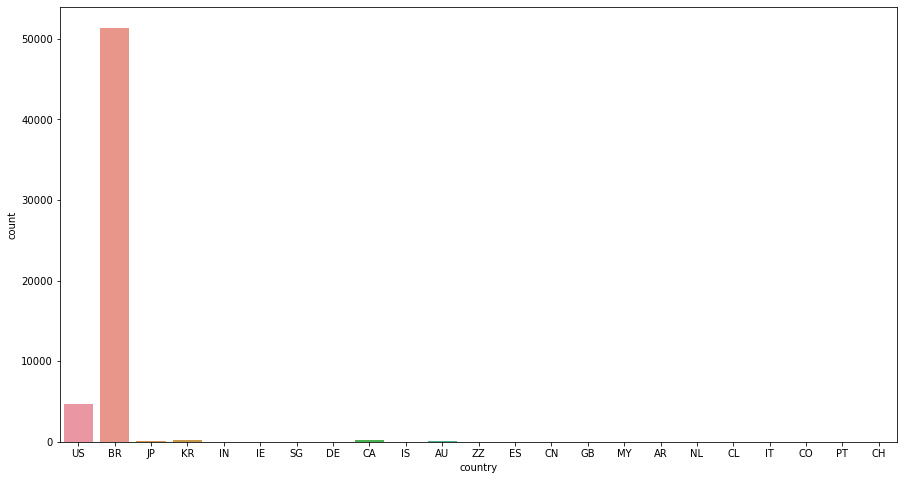

In [459]:
#plotting categorical variables 
categorical_variables =['interaction_type','country']
for i in range(0,len(categorical_variables)):
    plt.figure(figsize=(15,8))
    sns.countplot(x=categorical_variables[i], data=consumer_df)
    plt.show()

### Inference from the data
- Count of content_watched is highest. Majority people do not engage with the articles. They just watch and move to next article.
- Brazil and US are countries where these articles are mostly popular and read.

### Import Platform Data

In [460]:
platform_content_df=pd.read_csv("platform_content.csv")
platform_content_df.head()

,event_timestamp,interaction_type,item_id,producer_id,producer_session_id,producer_device_info,producer_location,producer_country,item_type,item_url,title,text_description,language
0,1459192779,content_pulled_out,-6451309518266745024,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dealbook/ethereum-a-virtual-currency-enables-transactions-that-rival-bitcoins.html,"Ethereum, a Virtual Currency, Enables Transactions That Rival Bitcoin's","All of this work is still very early. The first full public version of the Ethereum software was recently released, and the system could face some of the same technical and legal problems that hav...",en
1,1459193988,content_present,-4110354420726924665,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dealbook/ethereum-a-virtual-currency-enables-transactions-that-rival-bitcoins.html,"Ethereum, a Virtual Currency, Enables Transactions That Rival Bitcoin's","All of this work is still very early. The first full public version of the Ethereum software was recently released, and the system could face some of the same technical and legal problems that hav...",en
2,1459194146,content_present,-7292285110016212249,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://cointelegraph.com/news/bitcoin-future-when-gbpcoin-of-branson-wins-over-usdcoin-of-trump,Bitcoin Future: When GBPcoin of Branson Wins Over USDcoin of Trump,"The alarm clock wakes me at 8:00 with stream of advert-free broadcasting, charged at one satoshi per second. The current BTC exchange rate makes that snooze button a costly proposition! So I get u...",en
3,1459194474,content_present,-6151852268067518688,3891637997717104548,-1457532940883382585,NaN,NaN,NaN,HTML,https://cloudplatform.googleblog.com/2016/03/Google-Data-Center-360-Tour.html,Google Data Center 360° Tour,We're excited to share the Google Data Center 360° Tour - a YouTube 360° video that gives you an unprecedented and immersive look inside one of our data centers. There are several ways to view thi...,en
4,1459194497,content_present,2448026894306402386,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,https://bitcoinmagazine.com/articles/ibm-wants-to-evolve-the-internet-with-blockchain-technology-1459189322,"IBM Wants to ""Evolve the Internet"" With Blockchain Technology","The Aite Group projects the blockchain market could be valued at $400 million by 2019. For that reason, some of the biggest names in banking, industry and technology have entered into the space to...",en


In [461]:
platform_content_df.shape

(3122, 13)

In [462]:
platform_content_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3122 entries, 0 to 3121
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   event_timestamp       3122 non-null   int64 
 1   interaction_type      3122 non-null   object
 2   item_id               3122 non-null   int64 
 3   producer_id           3122 non-null   int64 
 4   producer_session_id   3122 non-null   int64 
 5   producer_device_info  680 non-null    object
 6   producer_location     680 non-null    object
 7   producer_country      680 non-null    object
 8   item_type             3122 non-null   object
 9   item_url              3122 non-null   object
 10  title                 3122 non-null   object
 11  text_description      3122 non-null   object
 12  language              3122 non-null   object
dtypes: int64(4), object(9)
memory usage: 317.2+ KB


### Exploratory data analysis

In [463]:
platform_content_df['producer_device_info'].value_counts()

Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/53.0.2785.116 Safari/537.36                   71
Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/55.0.2883.87 Safari/537.36               65
Android - Native Mobile App                                                                                                 35
Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/55.0.2883.87 Safari/537.36                    29
Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/53.0.2785.143 Safari/537.36                   28
                                                                                                                            ..
Mozilla/5.0 (X11; CrOS x86_64 8743.76.0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/54.0.2840.79 Safari/537.36            1
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/55.0.2883.95 Safa

In [464]:
platform_content_df['item_type'].value_counts()

HTML     3101
VIDEO      11
RICH       10
Name: item_type, dtype: int64

In [465]:
platform_content_df['interaction_type'].value_counts()

content_present       3047
content_pulled_out      75
Name: interaction_type, dtype: int64

In [466]:
platform_content_df['language'].value_counts()

en    2264
pt     850
la       4
es       2
ja       2
Name: language, dtype: int64

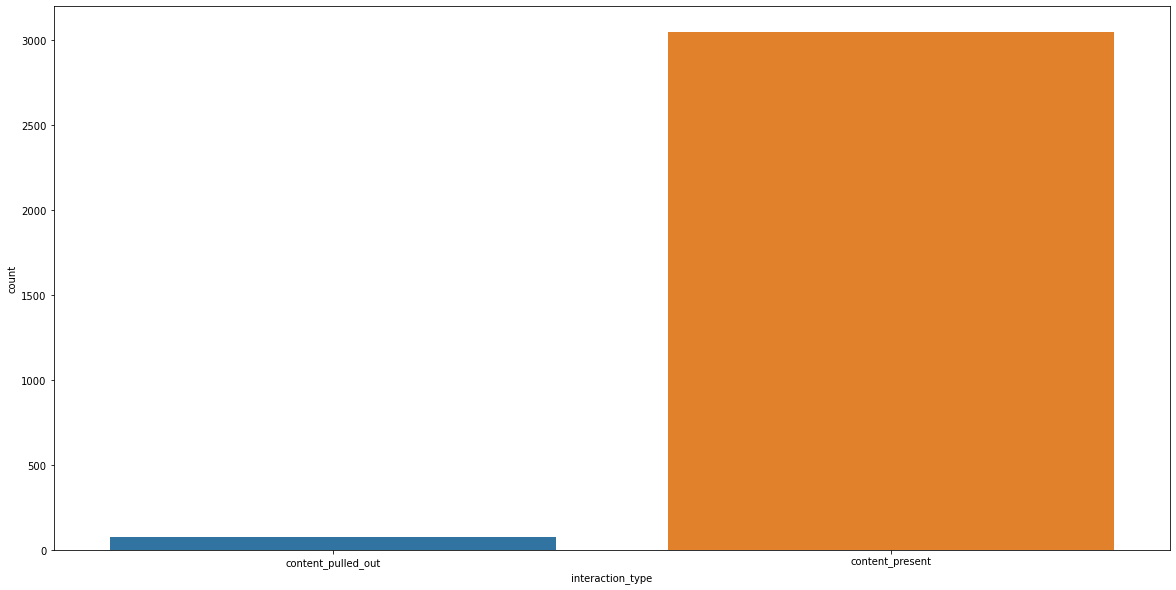

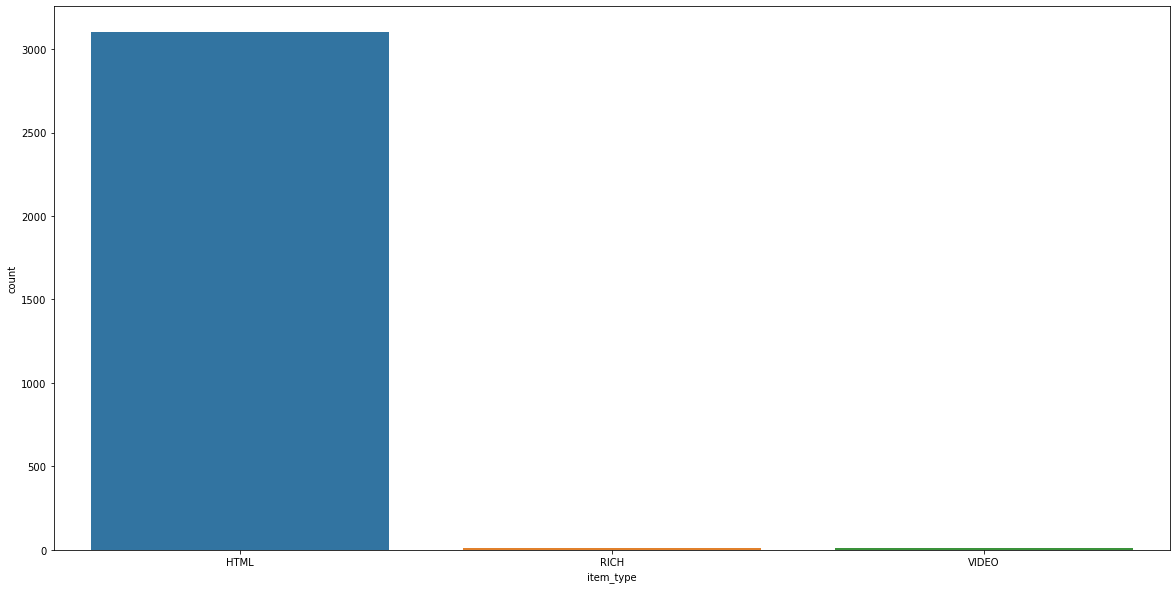

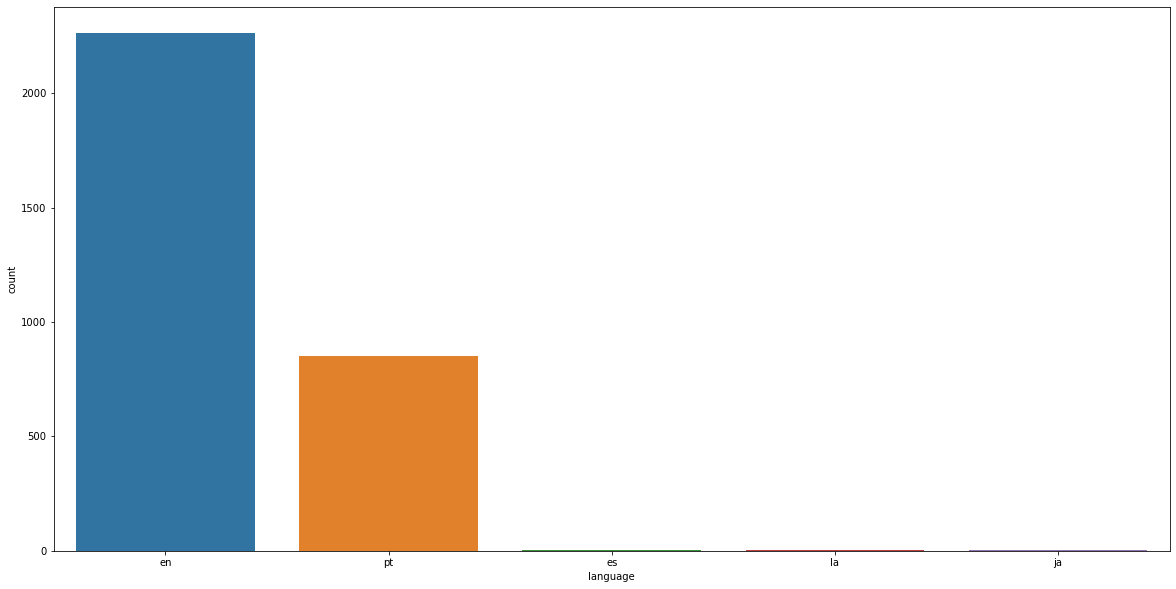

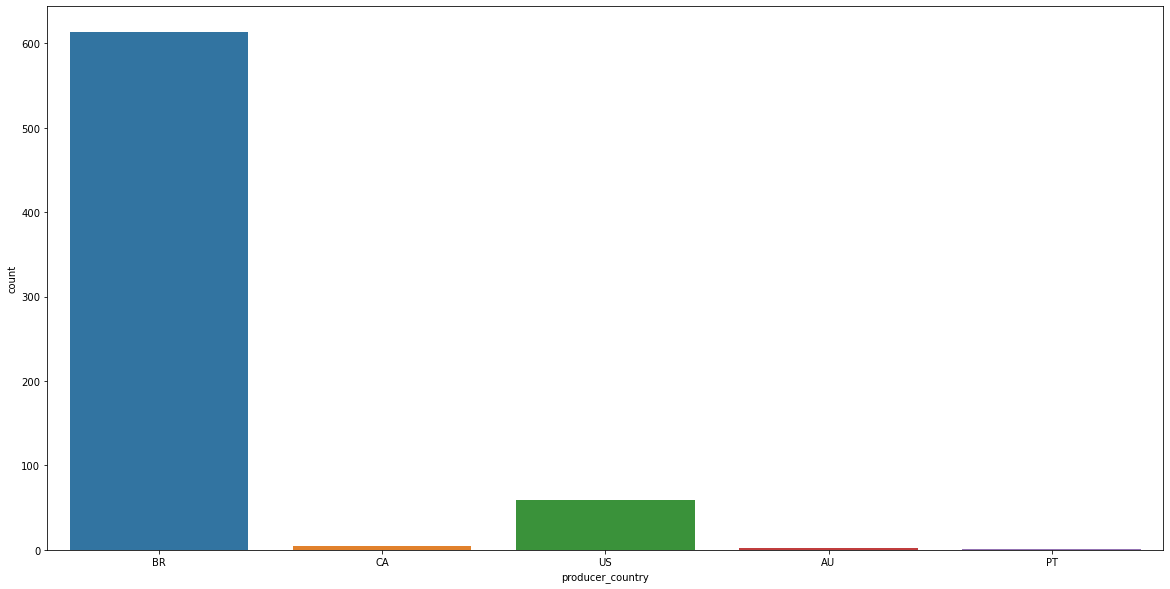

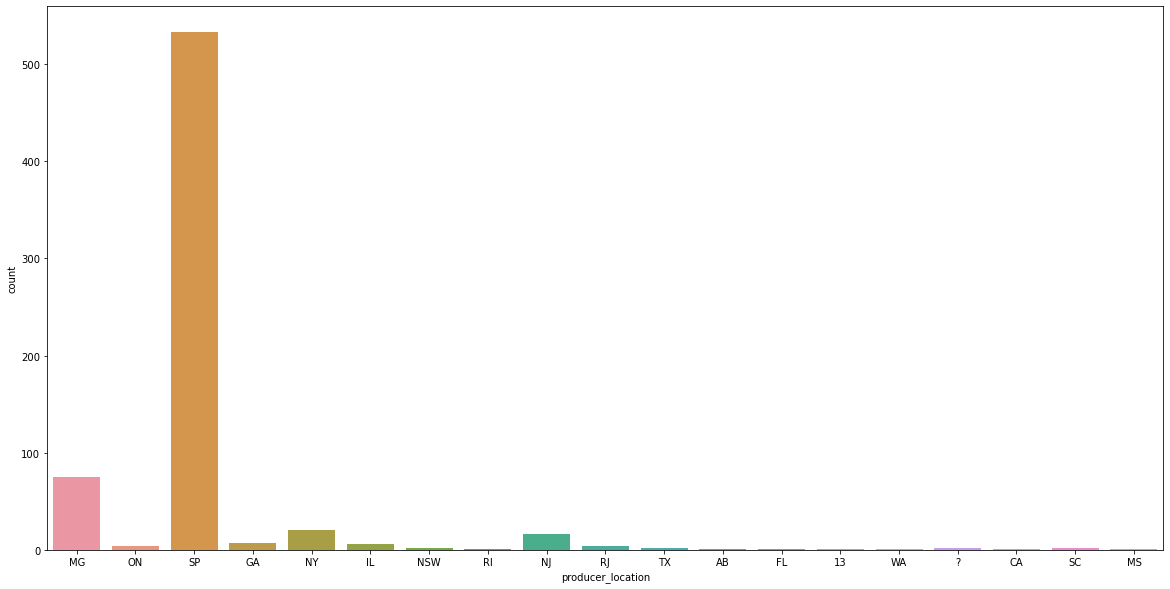

In [467]:
#function for barplot for categorical variables 
categorical_values =['interaction_type','item_type','language','producer_country','producer_location']

for i in range(0,len(categorical_values)):
    plt.figure(figsize=(20,10))
    sns.countplot(x=categorical_values[i], data=platform_content_df)
    plt.show()
    


### Inference from the data
- Two types of content present in the dataset- content that has been pulled out or the content which is present
- Most articles that are present are in HTML format.
- Most articles are in english language. 
- Brazil and US are the most popular countries which produce these articles.
- SP, MG, NJ, NY are the locations which consume these articles most.

### We will use only english language based articles for our recommendation

In [468]:
platform_content_en = platform_content_df[platform_content_df.language == 'en']

In [469]:
platform_content_en.shape

(2264, 13)

### We will separate the pulled out content for our recommendation

In [470]:
pulled_out_df= platform_content_en[platform_content_en.interaction_type == 'content_pulled_out']

In [471]:
pulled_out_df.shape

(53, 13)

In [472]:
platform_content_en = platform_content_en[platform_content_en.interaction_type != 'content_pulled_out']

In [473]:
platform_content_en.shape

(2211, 13)

In [474]:
platform_content_en.isna().sum()

event_timestamp            0
interaction_type           0
item_id                    0
producer_id                0
producer_session_id        0
producer_device_info    1744
producer_location       1744
producer_country        1744
item_type                  0
item_url                   0
title                      0
text_description           0
language                   0
dtype: int64

### Inference
- The attributes required for recommendation do not have any null values. producer_location and producer_country wouldn't take part in the model.

# Collaborative filtering : User based recommendation

In [475]:
consumer_df.head()

,event_timestamp,interaction_type,item_id,consumer_id,consumer_session_id,consumer_device_info,consumer_location,country,ratings
0,1465413032,content_watched,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NaN,1
1,1465412560,content_watched,8890720798209849691,-1032019229384696495,3621737643587579081,"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/52.0.2743.24 Safari/537.36",NY,US,1
2,1465416190,content_watched,310515487419366995,-1130272294246983140,2631864456530402479,NaN,NaN,NaN,1
3,1465413895,content_followed,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN,5
4,1465412290,content_watched,-7820640624231356730,-445337111692715325,561148 1178424124714,NaN,NaN,NaN,1


In [476]:
consumer_df.shape

(72312, 9)

In [477]:
consumer_df.isnull().sum()

event_timestamp             0
interaction_type            0
item_id                     0
consumer_id                 0
consumer_session_id         0
consumer_device_info    15394
consumer_location       15405
country                 15394
ratings                     0
dtype: int64

In [478]:
consumer_df.duplicated().sum()

11

In [479]:
#drop the duplicate records
consumer_df = consumer_df.drop_duplicates(subset=None, keep='first', inplace=False) 

In [480]:
consumer_df.shape

(72301, 9)

#### Removing records where content is pulled out

In [481]:
pulled_out=list(pulled_out_df['item_id'])
len(pulled_out)

53

In [482]:
consumer_df=consumer_df[~consumer_df['item_id'].isin(pulled_out)] 

In [483]:
consumer_df.shape

(72083, 9)

In [484]:
n_users = consumer_df.consumer_id.nunique()

n_items = consumer_df.item_id.nunique()

n_users, n_items

(1895, 2939)

In [485]:
#take columns required for user based recommendation
consumer_all_detail=consumer_df[['item_id','consumer_id','ratings']]
consumer_all_detail.head()

,item_id,consumer_id,ratings
0,-3499919498720038879,-8845298781299428018,1
1,8890720798209849691,-1032019229384696495,1
2,310515487419366995,-1130272294246983140,1
3,310515487419366995,344280948527967603,5
4,-7820640624231356730,-445337111692715325,1


#### Will simplify the values of item_id and consumer_id by encoding

In [486]:
def encode_column(column):
# Encodes a pandas column with continuous value
    keys = column.unique()
    #assign a value to key
    key_to_id = {key:idx for idx,key in enumerate(keys)}
    return key_to_id

In [487]:
item_dict=encode_column(consumer_all_detail['item_id'])
len(item_dict.keys())

2939

In [488]:
consumer_all_detail['item_idx'] = consumer_all_detail['item_id'].map(item_dict)

In [489]:
consumer_dict=encode_column(consumer_all_detail['consumer_id'])
len(consumer_dict.keys())

1895

In [490]:
consumer_all_detail['consumer_idx']=consumer_all_detail['consumer_id'].map(consumer_dict)

In [491]:
consumer_all_detail.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72083 entries, 0 to 72311
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   item_id       72083 non-null  int64
 1   consumer_id   72083 non-null  int64
 2   ratings       72083 non-null  int64
 3   item_idx      72083 non-null  int64
 4   consumer_idx  72083 non-null  int64
dtypes: int64(5)
memory usage: 3.3 MB


In [492]:
#creating other dataframe for further processing using new ID

In [493]:
consumer_idx_df=consumer_all_detail[['item_idx','consumer_idx','ratings']]
consumer_idx_df.head()

,item_idx,consumer_idx,ratings
0,0,0,1
1,1,1,1
2,2,2,1
3,2,3,5
4,3,4,1


## Dividing the data into test and train dataset

In [494]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(consumer_idx_df, test_size=0.30, random_state=31)

In [495]:
print(train.shape)
print(test.shape)

(50458, 3)
(21625, 3)


In [496]:
consumer_idx_df.shape

(72083, 3)

In [497]:
train.head()

,item_idx,consumer_idx,ratings
58321,2391,208,5
62101,2476,184,1
4550,41,48,1
55252,2235,262,1
29002,452,560,1


In [498]:
test.head()

,item_idx,consumer_idx,ratings
8887,850,926,1
58350,2436,1730,1
16258,493,241,1
18851,204,125,1
46663,2062,438,1


## Create empty data matrix: user*articles

In [499]:
data_matrix = np.zeros((n_users, n_items))

In [500]:
data_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [501]:
data_matrix.shape   

(1895, 2939)

## Fill user*articles Train matrix with rating values

In [502]:
for line in train.itertuples():
    if ((line[1]>1895)):
        continue #move on to next line if the consumer id is > 1895 
    data_matrix[line[1]-1, line[2]-1] = line[3]

In [503]:
data_matrix

array([[5., 1., 0., ..., 0., 0., 3.],
       [1., 1., 3., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [504]:
data_matrix.shape

(1895, 2939)

## Create Data Matrix with Test Data

In [505]:
data_matrix_test = np.zeros((n_users, n_items)) #create a zero matrix

In [506]:
data_matrix_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [507]:
data_matrix_test.shape

(1895, 2939)

In [508]:
for line in test.itertuples():
    if ((line[1]>1895) or (line[2]>2435)):
        continue
    data_matrix_test[line[1]-1, line[2]-1] = line[3]

In [509]:
data_matrix_test.shape

(1895, 2939)

### Create Data Matrix with full data

In [510]:
data_matrix_full = np.zeros((n_users, n_items))


In [511]:
for line in consumer_idx_df.itertuples():
    if ((line[1]>1895)):
        continue
    data_matrix_full[line[1]-1, line[2]-1] = line[3]


In [512]:
data_matrix_full

array([[1., 1., 0., ..., 0., 0., 3.],
       [1., 1., 1., ..., 0., 0., 0.],
       [3., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

# Pairwise Distance

In [513]:
from sklearn.metrics.pairwise import pairwise_distances 

In [514]:
#calculate distance between each vector for user
user_similarity = 1- pairwise_distances(data_matrix, metric='cosine')


In [515]:
user_similarity.shape

(1895, 1895)

In [516]:
user_similarity

array([[1.        , 0.09063669, 0.33218192, ..., 0.0675566 , 0.05943963,
        0.22333125],
       [0.09063669, 1.        , 0.04850713, ..., 0.        , 0.        ,
        0.11595421],
       [0.33218192, 0.04850713, 1.        , ..., 0.        , 0.        ,
        0.11952286],
       ...,
       [0.0675566 , 0.        , 0.        , ..., 1.        , 0.15526752,
        0.        ],
       [0.05943963, 0.        , 0.        , ..., 0.15526752, 1.        ,
        0.        ],
       [0.22333125, 0.11595421, 0.11952286, ..., 0.        , 0.        ,
        1.        ]])

## Articles pairwise similarity distance

In [517]:
item_similarity = 1-pairwise_distances(data_matrix.T, metric='cosine') #distance btween item vector

In [518]:
item_similarity.shape

(2939, 2939)

In [519]:
item_similarity

array([[1.        , 0.11008736, 0.02267722, ..., 0.        , 0.        ,
        0.18346796],
       [0.11008736, 1.        , 0.10734844, ..., 0.        , 0.        ,
        0.08832129],
       [0.02267722, 0.10734844, 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.18346796, 0.08832129, 0.        , ..., 0.        , 0.        ,
        1.        ]])

## Dot product of Data Matrix with similarity matrix

In [520]:
item_prediction = np.dot(user_similarity, data_matrix_test)

In [521]:
item_prediction

array([[1.23491300e+02, 5.46068744e+00, 1.92485736e-01, ...,
        0.00000000e+00, 0.00000000e+00, 1.49590284e+01],
       [5.32372784e+01, 4.20629290e+00, 1.21534482e+00, ...,
        0.00000000e+00, 0.00000000e+00, 6.26846256e+00],
       [8.58219220e+01, 3.07140109e+00, 2.59325636e-01, ...,
        0.00000000e+00, 0.00000000e+00, 8.27891832e+00],
       ...,
       [1.36970472e+01, 1.02671599e+00, 5.71661950e-02, ...,
        0.00000000e+00, 0.00000000e+00, 1.69046094e+00],
       [1.02660025e+01, 5.01020089e-01, 5.68761170e-02, ...,
        0.00000000e+00, 0.00000000e+00, 7.79758080e-01],
       [3.99178046e+01, 2.48415463e+00, 1.71682028e-01, ...,
        0.00000000e+00, 0.00000000e+00, 7.30583959e+00]])

In [522]:
item_prediction.shape

(1895, 2939)

In [523]:
prediction_df = pd.DataFrame(item_prediction)#create df 

In [524]:
prediction_df.shape

(1895, 2939)

In [525]:
prediction_df.head()

,0,1,2,3,4,5,6,7,8,9,...,2929,2930,2931,2932,2933,2934,2935,2936,2937,2938
0,123.491300,5.460687,0.192486,5.984114,0.519614,36.424629,2.387528,4.466404,1.507105,3.153628,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.959028
1,53.237278,4.206293,1.215345,3.320641,0.537730,20.150260,1.421576,4.867395,1.405952,2.186025,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.268463
2,85.821922,3.071401,0.259326,6.659791,0.133333,18.663883,1.255912,2.556530,0.584607,1.775120,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.278918
3,15.456576,1.510254,0.141758,1.569754,0.201724,17.862224,1.059456,1.835731,0.999882,1.294378,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.285014
4,26.538133,1.795271,0.101131,1.409825,0.261501,24.153074,3.418447,1.809636,2.463852,2.084262,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.429995


# Model evaluation

In [526]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from math import sqrt

## MAE: Mean Absolute Error

In [527]:
def mae(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()]
    ground_truth = ground_truth[ground_truth.nonzero()]
    return mean_absolute_error(prediction, ground_truth)

In [528]:
mae(item_prediction,data_matrix_test) 

8.282068533589495

## Inference
### Lower score of MAE indicates better model, we have low value for MAE hence we can conclude it is a good model

## RMSE: Root Mean Squared Error

In [529]:
def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()]
    ground_truth = ground_truth[ground_truth.nonzero()]
    return sqrt(mean_squared_error(prediction, ground_truth))

In [530]:
rmse(item_prediction,data_matrix_test)

18.128811574742976

## Inference
### Lower score of RMSE indicates better model, we have low value for RMSE hence we can conclude it is a good model

### Getting recommendation for consumer id 8239286975497580612

In [531]:
consumer_dict[8239286975497580612]

10

In [532]:
prediction_df.iloc[consumer_dict[8239286975497580612]]

0       7.380693
1       0.162537
2       0.000000
3       0.212853
4       0.057378
          ...   
2934    0.000000
2935    0.000000
2936    0.000000
2937    0.000000
2938    0.415398
Name: 10, Length: 2939, dtype: float64

In [533]:
prediction_df.iloc[consumer_dict[8239286975497580612]].sort_values(ascending=False)[:15] #top 15 after sorting

5      7.615451
0      7.380693
19     7.154092
256    6.526580
381    6.040718
500    5.859335
25     5.750275
194    5.446047
71     4.188860
79     3.850002
465    3.767035
83     3.764432
616    3.471578
122    3.241737
50     3.205688
Name: 10, dtype: float64

In [534]:
recommended_article_df = pd.DataFrame(prediction_df.iloc[consumer_dict[8239286975497580612]].sort_values(ascending=False))

In [535]:
recommended_article_df.head()

,10
5,7.615451
0,7.380693
19,7.154092
256,6.526580
381,6.040718


In [536]:
recommended_article_df.reset_index(inplace=True)

In [537]:
recommended_article_df.head()

,index,10
0,5,7.615451
1,0,7.380693
2,19,7.154092
3,256,6.526580
4,381,6.040718


In [538]:
recommended_article_df.columns = ['item_idx', 'score']

In [539]:
recommended_article_df.head()

,item_idx,score
0,5,7.615451
1,0,7.380693
2,19,7.154092
3,256,6.526580
4,381,6.040718


In [540]:
merged_user = pd.merge(recommended_article_df, consumer_all_detail[consumer_all_detail.consumer_id!=8239286975497580612], on='item_idx', how='left') #merge to get original ids

In [541]:
merged_user.head(10)

,item_idx,score,item_id,consumer_id,ratings,consumer_idx
0,5,7.615451,-1492913151930215984,4254153380739593270,1,7
1,5,7.615451,-1492913151930215984,4254153380739593270,1,7
2,5,7.615451,-1492913151930215984,3609194402293569455,1,6
3,5,7.615451,-1492913151930215984,3609194402293569455,1,6
4,5,7.615451,-1492913151930215984,7022645187549453002,1,14
5,5,7.615451,-1492913151930215984,7022645187549453002,1,14
6,5,7.615451,-1492913151930215984,3609194402293569455,2,6
7,5,7.615451,-1492913151930215984,3024551089288349719,1,473
8,5,7.615451,-1492913151930215984,3024551089288349719,1,473
9,5,7.615451,-1492913151930215984,7774613525190730745,1,339


In [542]:
merged_user_x_article=pd.merge(merged_user[['item_id','score']],platform_content_en[['item_id','title']],on='item_id', how='left') #merge to get title

In [543]:
merged_user_x_article

,item_id,score,title
0,-1492913151930215984,7.615451,Chrome DevTools - Console API Reference
1,-1492913151930215984,7.615451,Chrome DevTools - Console API Reference
2,-1492913151930215984,7.615451,Chrome DevTools - Console API Reference
3,-1492913151930215984,7.615451,Chrome DevTools - Console API Reference
4,-1492913151930215984,7.615451,Chrome DevTools - Console API Reference
...,...,...,...
71964,5653476548835345267,0.000000,The New Wall Street: Even Big Banks Want Help Navigating Markets
71965,5653476548835345267,0.000000,The New Wall Street: Even Big Banks Want Help Navigating Markets
71966,5653476548835345267,0.000000,The New Wall Street: Even Big Banks Want Help Navigating Markets
71967,-6725796505137573953,0.000000,Stratumn is building a sort of Heroku for blockchain applications - The Bitcoin Channel


In [544]:
merged_user_x_article['user_score_normalized'] = (merged_user_x_article['score']-min(merged_user_x_article['score'])) / (max(merged_user_x_article['score']) - min(merged_user_x_article['score']))

In [545]:
merged_user_x_article = merged_user_x_article.drop_duplicates(subset=None, keep='first', inplace=False) 
merged_user_x_article = merged_user_x_article[merged_user_x_article.title.notna()]

In [546]:
merged_user_x_article.shape

(2106, 4)

In [547]:
top10=merged_user_x_article.head(10)

In [548]:
top10[['item_id','title']]

,item_id,title
0,-1492913151930215984,Chrome DevTools - Console API Reference
54,-3499919498720038879,Hiri wants to fix the workplace email problem
74,-4205346868684833897,"Google launches Springboard, an AI-powered assistant for its enterprise customers"
152,-6858665134018491791,Chat Smarter with Allo
230,8969476626572775042,What it Means to Be a 'Growth Hacker' According to Julie Zhou
239,-4615575698508618335,Facebook Messenger bots are here and they want to kill apps
245,-1590585250246572231,Why and How to Avoid Hamburger Menus - Louie A. - Mobile UX Design
276,8657408509986329668,Pull request first - Practical Blend
567,-3027055440570405664,Joel on Software
651,865977730460714234,Waking Ned Devine (1998)


# Precision@K 

In [549]:
pred_set = merged_user_x_article['item_id'].values[:10]

In [550]:
pred_set

array([-1492913151930215984, -3499919498720038879, -4205346868684833897,
       -6858665134018491791,  8969476626572775042, -4615575698508618335,
       -1590585250246572231,  8657408509986329668, -3027055440570405664,
         865977730460714234], dtype=int64)

In [551]:
ratings_filtered = consumer_all_detail[(consumer_all_detail['consumer_id']==8239286975497580612) & (consumer_all_detail['ratings']>=3)].sort_values(by='ratings',ascending=False)

In [552]:
ratings_filtered.head()

,item_id,consumer_id,ratings,item_idx,consumer_idx
14367,8402348887626635381,8239286975497580612,3,306,10
30446,3322348437880079228,8239286975497580612,3,1030,10
53579,5410293063635507608,8239286975497580612,3,2301,10


### Inference
### Out of 10 recommended articles, user liked 3 of them, hence precision@10=30%

In [553]:
def user_based_collaborative(user_id): #creating func for user based filtering
    recommended_article_df = pd.DataFrame(prediction_df.iloc[consumer_dict[user_id]].sort_values(ascending=False))
    recommended_article_df.reset_index(inplace=True)
    recommended_article_df.columns = ['item_idx', 'score']
    
    #filtered and merged data. Removing those articles which user has already read
    merged_user = pd.merge(recommended_article_df,consumer_all_detail[consumer_all_detail.consumer_id!=user_id] , on='item_idx', how='left') 
    merged_user_title=pd.merge(merged_user[['item_id','score']],platform_content_en[['item_id','title']],on='item_id', how='left')
     
    #remove duplicates by keeping first original rows
    user_fil_df = merged_user_title.drop_duplicates(subset=None, keep='first', inplace=False)
    
    #remove titles which are null
    user_fil_df = user_fil_df[user_fil_df['title'].notna()]
    
    #normalize score
    user_fil_df['user_score_normalized'] = (user_fil_df['score']-min(user_fil_df['score'])) / (max(user_fil_df['score']) - min(user_fil_df['score'])) 
    return user_fil_df

    

In [554]:
print("USER BASED collaborative recommendation model output for consumer id -709287718034731589")
user_fil_df=user_based_collaborative(-709287718034731589)
top10=user_fil_df.head(10)
top10[['item_id','title']]

USER BASED collaborative recommendation model output for consumer id -709287718034731589


,item_id,title
4467,-1.523691e+15,Measuring email effectiveness in retail banking
5153,-2.871289e+15,"Dilma Rousseff's Impeachment Isn't a Coup, It's a Cover-Up"
9456,-1.254907e+18,Enterprise developers look out: this week on Google Cloud Platform
12654,1.024703e+16,[Tools] 12 Apps for Live-streaming Video
20383,2.308074e+17,Ethereum Used for 'First' Paid Energy Trade Using Blockchain Tech - CoinDesk
31750,-1.975048e+17,Tom Brady: Business Guru. Who Knew?
32548,-1.151035e+18,New JavaScript library brings Java to browsers without applets
35997,-6.051144e+17,"A sneak peek at Google's upcoming travel app, Trips"
44969,-1.150591e+18,Digitization and The Loss of Iconography - Posted by SYPartners
46861,3.134908e+16,"9 trends you need to watch at CES 2017, from 'AI' assistants to 'AR' devices"


# Collaborative Filtering: Item Based Recommendations

In [555]:
n_users, n_items

(1895, 2939)

In [556]:
data_matrix_full.shape

(1895, 2939)

In [557]:
item_matrix=data_matrix_full.T

In [558]:
item_matrix

array([[1., 1., 3., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [3., 0., 0., ..., 0., 0., 1.]])

In [559]:
item_matrix.shape

(2939, 1895)

# Pairwise Distance

## Article pairwise similarity distance

In [560]:
item_similarity = 1- pairwise_distances(item_matrix, metric='cosine')


In [561]:
item_similarity

array([[1.        , 0.09958483, 0.01181799, ..., 0.        , 0.        ,
        0.16308074],
       [0.09958483, 1.        , 0.03663717, ..., 0.        , 0.        ,
        0.05347372],
       [0.01181799, 0.03663717, 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.16308074, 0.05347372, 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [562]:
item_similarity.shape

(2939, 2939)

## Get similar recommended articles for a article id

In [563]:
article_prediction = pd.DataFrame(item_similarity)

In [564]:
article_prediction.head()

,0,1,2,3,4,5,6,7,8,9,...,2929,2930,2931,2932,2933,2934,2935,2936,2937,2938
0,1.000000,0.099585,0.011818,0.135463,0.045771,0.299004,0.057683,0.094523,0.021988,0.068996,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.163081
1,0.099585,1.000000,0.036637,0.055993,0.063065,0.133820,0.019869,0.110877,0.011361,0.048612,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.053474
2,0.011818,0.036637,1.000000,0.000000,0.258199,0.071270,0.000000,0.043234,0.062017,0.053074,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,0.135463,0.055993,0.000000,1.000000,0.032884,0.136154,0.062164,0.132150,0.059239,0.060836,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.050697
4,0.045771,0.063065,0.258199,0.032884,1.000000,0.099676,0.093352,0.148839,0.026688,0.022840,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.011420


In [565]:
article_prediction.shape

(2939, 2939)

In [566]:
item_dict

{-3499919498720038879: 0,
 8890720798209849691: 1,
 310515487419366995: 2,
 -7820640624231356730: 3,
 -8864073373672512525: 4,
 -1492913151930215984: 5,
 3064370296170038610: 6,
 3460026829794173084: 7,
 7763750328910542816: 8,
 2372438485070148864: 9,
 -348408475077850711: 10,
 372531153711028286: 11,
 6521856301289868251: 12,
 -8142426490949346803: 13,
 7943088471380012839: 14,
 1441248639512899483: 15,
 4306804750094230211: 16,
 1582315529508020223: 17,
 -5924996404988010: 18,
 -4205346868684833897: 19,
 7276478113479207148: 20,
 3492139128548911513: 21,
 3727587882617538492: 22,
 -692972306229904743: 23,
 -7777013191403056825: 24,
 -4615575698508618335: 25,
 4761910285123871012: 26,
 5688279681867464747: 27,
 -1470592927114056630: 28,
 3172866488852888544: 29,
 -2261845840076552387: 30,
 -998818216447049475: 31,
 -2181071289972835602: 32,
 1964631817676172382: 33,
 -8418620743404378592: 34,
 1431351528207086249: 35,
 -8971085667828564532: 36,
 -5557505576293652420: 37,
 55080436595

## getting similar articles like item_id  3064370296170038610

In [567]:
article_prediction.iloc[item_dict[3064370296170038610]]

0       0.057683
1       0.019869
2       0.000000
3       0.062164
4       0.093352
          ...   
2934    0.000000
2935    0.000000
2936    0.000000
2937    0.000000
2938    0.014392
Name: 6, Length: 2939, dtype: float64

In [568]:
item_recommendation = pd.DataFrame(article_prediction.iloc[item_dict[3064370296170038610]].sort_values(ascending=False)) #sorting

In [569]:
item_recommendation.head()

,6
6,1.000000
584,0.266789
978,0.264706
125,0.241189
72,0.236448


In [570]:
item_recommendation.reset_index(inplace=True)

In [571]:
item_recommendation.head()

,index,6
0,6,1.000000
1,584,0.266789
2,978,0.264706
3,125,0.241189
4,72,0.236448


In [572]:
item_recommendation.columns = ['item_idx', 'score']

In [573]:
item_recommendation.head()

,item_idx,score
0,6,1.000000
1,584,0.266789
2,978,0.264706
3,125,0.241189
4,72,0.236448


In [574]:
merged = pd.merge(item_recommendation, consumer_all_detail, on='item_idx', how='left') #merge

In [575]:
merged.head()

,item_idx,score,item_id,consumer_id,ratings,consumer_idx
0,6,1.0,3064370296170038610,3609194402293569455,1,6
1,6,1.0,3064370296170038610,3609194402293569455,1,6
2,6,1.0,3064370296170038610,2290322765105220968,1,450
3,6,1.0,3064370296170038610,2290322765105220968,1,450
4,6,1.0,3064370296170038610,5705041016417759824,1,290


In [576]:
merged_user_article=pd.merge(merged,platform_content_en[['item_id','title']],on='item_id', how='left')

In [577]:
merged_user_article

,item_idx,score,item_id,consumer_id,ratings,consumer_idx,title
0,6,1.0,3064370296170038610,3609194402293569455,1,6,"Google, Amazon and the upcoming battle over AI Assistants"
1,6,1.0,3064370296170038610,3609194402293569455,1,6,"Google, Amazon and the upcoming battle over AI Assistants"
2,6,1.0,3064370296170038610,2290322765105220968,1,450,"Google, Amazon and the upcoming battle over AI Assistants"
3,6,1.0,3064370296170038610,2290322765105220968,1,450,"Google, Amazon and the upcoming battle over AI Assistants"
4,6,1.0,3064370296170038610,5705041016417759824,1,290,"Google, Amazon and the upcoming battle over AI Assistants"
...,...,...,...,...,...,...,...
72078,1523,0.0,-4318248821095057296,-2979881261169775358,1,113,Gmail API: New endpoints for settings
72079,1523,0.0,-4318248821095057296,-1032019229384696495,1,1,Gmail API: New endpoints for settings
72080,1523,0.0,-4318248821095057296,753551422329466662,1,848,Gmail API: New endpoints for settings
72081,1469,0.0,-6725796505137573953,-8051903121006324833,1,1161,Stratumn is building a sort of Heroku for blockchain applications - The Bitcoin Channel


In [578]:
collab_output = merged_user_article[merged_user_article['title'].notna()] #no NA 

In [579]:
collab_output.shape

(46840, 7)

In [580]:
collab_output.head(10)

,item_idx,score,item_id,consumer_id,ratings,consumer_idx,title
0,6,1.0,3064370296170038610,3609194402293569455,1,6,"Google, Amazon and the upcoming battle over AI Assistants"
1,6,1.0,3064370296170038610,3609194402293569455,1,6,"Google, Amazon and the upcoming battle over AI Assistants"
2,6,1.0,3064370296170038610,2290322765105220968,1,450,"Google, Amazon and the upcoming battle over AI Assistants"
3,6,1.0,3064370296170038610,2290322765105220968,1,450,"Google, Amazon and the upcoming battle over AI Assistants"
4,6,1.0,3064370296170038610,5705041016417759824,1,290,"Google, Amazon and the upcoming battle over AI Assistants"
5,6,1.0,3064370296170038610,-3596626804281480007,1,80,"Google, Amazon and the upcoming battle over AI Assistants"
6,6,1.0,3064370296170038610,5705041016417759824,1,290,"Google, Amazon and the upcoming battle over AI Assistants"
7,6,1.0,3064370296170038610,-3596626804281480007,1,80,"Google, Amazon and the upcoming battle over AI Assistants"
8,6,1.0,3064370296170038610,-1443636648652872475,1,26,"Google, Amazon and the upcoming battle over AI Assistants"
9,6,1.0,3064370296170038610,-1479311724257856983,1,12,"Google, Amazon and the upcoming battle over AI Assistants"


In [581]:
collab_output['collaborative_score_normalized'] = (collab_output['score']-min(collab_output['score']))/(max(collab_output['score'])-min(collab_output['score']))

In [582]:
collab_output.head()

,item_idx,score,item_id,consumer_id,ratings,consumer_idx,title,collaborative_score_normalized
0,6,1.0,3064370296170038610,3609194402293569455,1,6,"Google, Amazon and the upcoming battle over AI Assistants",1.0
1,6,1.0,3064370296170038610,3609194402293569455,1,6,"Google, Amazon and the upcoming battle over AI Assistants",1.0
2,6,1.0,3064370296170038610,2290322765105220968,1,450,"Google, Amazon and the upcoming battle over AI Assistants",1.0
3,6,1.0,3064370296170038610,2290322765105220968,1,450,"Google, Amazon and the upcoming battle over AI Assistants",1.0
4,6,1.0,3064370296170038610,5705041016417759824,1,290,"Google, Amazon and the upcoming battle over AI Assistants",1.0


In [583]:
collab_output['title'].unique()[:10]

array(['Google, Amazon and the upcoming battle over AI Assistants',
       'Enterprise developers look out: this week on Google Cloud Platform',
       'Hero unveils a new home gadget to help you track and dispense pills',
       'The Challenge of Determining Whether an A.I. Is Sentient',
       'The Continuous Delivery Maturity Model',
       'Android Quickstart - Firebase',
       '\u200bGoogle digs deeper on machine learning with new European research lab',
       'Object calisthenics: Change the way you code',
       'Ahead of the curve: The future of performance management',
       'Android N Developer Preview 2, out today! | Android Developers Blog'],
      dtype=object)

In [584]:
platform_content_en[platform_content_en['item_id']==3064370296170038610]

,event_timestamp,interaction_type,item_id,producer_id,producer_session_id,producer_device_info,producer_location,producer_country,item_type,item_url,title,text_description,language
1307,1465397153,content_present,3064370296170038610,-1443636648652872475,-5844499583089646160,NaN,NaN,NaN,HTML,https://www.linkedin.com/pulse/google-amazon-upcoming-battle-over-ai-assistants-dennis-r-mortensen,"Google, Amazon and the upcoming battle over AI Assistants","The stage is set for the coming battle between the big five tech giants: Google, Apple, Facebook, Microsoft, and Amazon (wait, make that four tech giants and one really tech savvy retailer). All a...",en


In [585]:
def item_based_recommendation(title_id): #func for item based filtering 
    item_recommendation = pd.DataFrame(article_prediction.iloc[item_dict[title_id]].sort_values(ascending=False))
    item_recommendation.reset_index(inplace=True)
    item_recommendation.columns = ['item_idx', 'score']
    merged = pd.merge(item_recommendation, consumer_all_detail[['item_id','item_idx']], on='item_idx', how='left')
    merged_user_title=pd.merge(merged,platform_content_en[['item_id','title']],on='item_id', how='left')
    merged_user_title = merged_user_title.drop_duplicates(subset=None, keep='first', inplace=False) #remove duplicates by keeping first original rows
    item_fil_df = merged_user_title[merged_user_title['title'].notna()]
    item_fil_df['item_score_normalized'] = (item_fil_df['score']-min(item_fil_df['score']))/(max(item_fil_df['score'])-min(item_fil_df['score']))
    return item_fil_df

    
    

In [586]:
platform_content_en[platform_content_en['item_id']==8076265166566225141]

,event_timestamp,interaction_type,item_id,producer_id,producer_session_id,producer_device_info,producer_location,producer_country,item_type,item_url,title,text_description,language
1036,1463696081,content_present,8076265166566225141,-1130272294246983140,788079039024593379,NaN,NaN,NaN,HTML,http://www.zeldman.com/2015/12/24/the-year-in-design/,The Year in Design - Zeldman on Web & Interaction Design,"Mobile is today's first screen. So design responsively, focusing on content and structure first. Websites and apps alike should remove distractions and let people interact as directly as possible ...",en


In [587]:
print("ITEM BASED")
print("Below are the top10 similar articles for article id 8076265166566225141:")
top10=item_based_recommendation(8076265166566225141).head(10)
top10[['item_id','title']]

ITEM BASED
Below are the top10 similar articles for article id 8076265166566225141:


,item_id,title
0,8076265166566225141,The Year in Design - Zeldman on Web & Interaction Design
8,-1634742667970363668,Google Cloud Platform's preemptible VMs are now up to 33% cheaper
59,-1492913151930215984,Chrome DevTools - Console API Reference
113,-7681408188643141872,The End Of Apps As We Know Them - Inside Intercom
202,-4205346868684833897,"Google launches Springboard, an AI-powered assistant for its enterprise customers"
538,5772565485432112058,U.S. State Department Recommends Development of Blockchain and Distributed Ledgers to International Partners
542,-5791454671270548045,"Google Cloud Dataproc - the fast, easy and safe way to try Spark 2.0-preview | Google Cloud Big Data and Machine Learning Blog"
559,-4571929941432664145,Machine Learning as a Service: How Data Science Is Hitting the Masses
679,-3499919498720038879,Hiri wants to fix the workplace email problem
699,5333141914314968598,"Microsoft HoloLens and Lowe's, working to redefine your next home renovation"


# Content based recommendation

In [588]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

In [589]:
platform_content_en.duplicated().sum()

0

#### Inference
- no duplicate rows

In [590]:
platform_content_en.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2211 entries, 1 to 3121
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   event_timestamp       2211 non-null   int64 
 1   interaction_type      2211 non-null   object
 2   item_id               2211 non-null   int64 
 3   producer_id           2211 non-null   int64 
 4   producer_session_id   2211 non-null   int64 
 5   producer_device_info  467 non-null    object
 6   producer_location     467 non-null    object
 7   producer_country      467 non-null    object
 8   item_type             2211 non-null   object
 9   item_url              2211 non-null   object
 10  title                 2211 non-null   object
 11  text_description      2211 non-null   object
 12  language              2211 non-null   object
dtypes: int64(4), object(9)
memory usage: 241.8+ KB


In [591]:
df_keywords = platform_content_en[['item_id','title','text_description']]

In [592]:
df_keywords.head()

,item_id,title,text_description
1,-4110354420726924665,"Ethereum, a Virtual Currency, Enables Transactions That Rival Bitcoin's","All of this work is still very early. The first full public version of the Ethereum software was recently released, and the system could face some of the same technical and legal problems that hav..."
2,-7292285110016212249,Bitcoin Future: When GBPcoin of Branson Wins Over USDcoin of Trump,"The alarm clock wakes me at 8:00 with stream of advert-free broadcasting, charged at one satoshi per second. The current BTC exchange rate makes that snooze button a costly proposition! So I get u..."
3,-6151852268067518688,Google Data Center 360° Tour,We're excited to share the Google Data Center 360° Tour - a YouTube 360° video that gives you an unprecedented and immersive look inside one of our data centers. There are several ways to view thi...
4,2448026894306402386,"IBM Wants to ""Evolve the Internet"" With Blockchain Technology","The Aite Group projects the blockchain market could be valued at $400 million by 2019. For that reason, some of the biggest names in banking, industry and technology have entered into the space to..."
5,-2826566343807132236,IEEE to Talk Blockchain at Cloud Computing Oxford-Con - CoinDesk,"One of the largest and oldest organizations for computing professionals will kick off its annual conference on the future of mobile cloud computing tomorrow, where blockchain is scheduled to be on..."


### Create numpy array from text_description column

In [593]:
keywords_array = df_keywords['text_description'].to_numpy()

In [594]:
keywords_array

array(['All of this work is still very early. The first full public version of the Ethereum software was recently released, and the system could face some of the same technical and legal problems that have tarnished Bitcoin. Many Bitcoin advocates say Ethereum will face more security problems than Bitcoin because of the greater complexity of the software. Thus far, Ethereum has faced much less testing, and many fewer attacks, than Bitcoin. The novel design of Ethereum may also invite intense scrutiny by authorities given that potentially fraudulent contracts, like the Ponzi schemes, can be written directly into the Ethereum system. But the sophisticated capabilities of the system have made it fascinating to some executives in corporate America. IBM said last year that it was experimenting with Ethereum as a way to control real world objects in the so-called Internet of things. Microsoft has been working on several projects that make it easier to use Ethereum on its computing cloud, Azu

In [595]:
len(keywords_array)

2211

In [596]:
type(keywords_array[0])

str

### Generate Words from Keywords Array by Splitting


In [597]:
words_list = []
for keyword in keywords_array:
    splitted_words = keyword.lower().split()
    words_list.append(splitted_words)

In [598]:
len(words_list), len(words_list[0]), len(words_list[1])

(2211, 1072, 311)

### Create dictionary

In [599]:
from gensim.corpora.dictionary import Dictionary

In [600]:
dictionary = Dictionary(words_list) 

In [601]:
len(dictionary)

113134

### Create corpus where the corpus is a bag of words for each document

In [602]:
corpus = [dictionary.doc2bow(doc) for doc in words_list] 
len(corpus)

2211

### Create tf-idf model

In [603]:
from gensim.models.tfidfmodel import TfidfModel
tfidf = TfidfModel(corpus) 

### Create similarity matrix for articles

In [604]:
from gensim.similarities import MatrixSimilarity
sims = MatrixSimilarity(tfidf[corpus], num_features=len(dictionary))

### Create a model and run recommendation

In [605]:
def article_recommendation(item_id):
    article = df_keywords.loc[df_keywords.item_id==item_id] # get the article row
    keywords = article['text_description'].iloc[0].split() #get the keywords as a Series,
    # get just the keywords string ([0]), and then convert to a list of keywords (.split() )
    
    #set the query_doc to the list of keywords
    query_doc = keywords 
    
    # get a bag of words from the query_doc
    query_doc_bow = dictionary.doc2bow(query_doc)
    
    #convert the regular bag of words model to a tf-idf model
    query_doc_tfidf = tfidf[query_doc_bow] 
    
     # get the array of similarity values between our article and every other article. 
    similarity_array = sims[query_doc_tfidf]
    #So the length is the number of articles we have. To do this, we pass our list of tf-idf tuples to sims
    
    
    similarity_series = pd.Series(similarity_array.tolist(), index=df_keywords.title.values)
    recommended_articles = similarity_series.sort_values(ascending=False)
    return recommended_articles

In [606]:
pd.set_option('max_colwidth', 100)

In [607]:
df_keywords.iloc[5]

item_id                                                                                            -2148899391355011268
title                                                     Banks Need To Collaborate With Bitcoin and Fintech Developers
text_description    It will take time until banks come around to the idea of embracing Bitcoin or Fintech, though. B...
Name: 6, dtype: object

In [608]:
#article_recommendation(-2148899391355011268)

In [609]:
similar_articles=article_recommendation(-2148899391355011268)
print(similar_articles[:10])

Banks Need To Collaborate With Bitcoin and Fintech Developers                       0.814491
The Future of Digital Banking is Now                                                0.267962
Digital Tool as Strategic Enabler for Banking Transformation                        0.254537
Is FinTech Forcing Banking to a Tipping Point?                                      0.251908
What Is Open Banking and Why is it Important?                                       0.248604
Welcome to GoogleBank, Facebook Bank, Amazon Bank, and Apple Bank - Enrique Dans    0.207781
Building a digital-banking business                                                 0.207443
Why Barclays Sees Banking's Future as an Information Business                       0.199502
Blockchain Will Be Used By 15% of Big Banks By 2017                                 0.195421
A digital crack in banking's business model                                         0.183100
dtype: float64


In [610]:
def content_based_filtering(item_id):
    
    #recommend articles for any article
    content_output = article_recommendation(item_id) 
    
    #create df of the content output
    content_df = pd.DataFrame(content_output)
    content_df.reset_index(inplace=True)
    content_df.columns = ['title', 'score']
    
    #merge
    content_df=pd.merge(content_df, df_keywords[['item_id','title','text_description']],on='title',how='left' ) 
    content_df.sort_values(by='score', ascending=False,inplace=True)
    
    #normalized score
    content_df['content_score_normalized'] = (content_df['score']-min(content_df['score'])) / (max(content_df['score']) - min(content_df['score'])) #normalize score
    return content_df

In [611]:
print("CONTENT BASED RECOMMENDATION")
content_df=content_based_filtering(-2148899391355011268)
content_df[['item_id','title']].head(10)

CONTENT BASED RECOMMENDATION


,item_id,title
0,-2148899391355011268,Banks Need To Collaborate With Bitcoin and Fintech Developers
1,2727743992157210358,The Future of Digital Banking is Now
2,5929055844564382383,Digital Tool as Strategic Enabler for Banking Transformation
3,-205193648629294862,Is FinTech Forcing Banking to a Tipping Point?
4,5028081187109329892,What Is Open Banking and Why is it Important?
5,2072448887839540892,"Welcome to GoogleBank, Facebook Bank, Amazon Bank, and Apple Bank - Enrique Dans"
6,-7002558676365724983,Building a digital-banking business
7,-634395794651424614,Why Barclays Sees Banking's Future as an Information Business
8,8631616594020837056,Blockchain Will Be Used By 15% of Big Banks By 2017
9,7516228655554309785,A digital crack in banking's business model


# ALS model

In [612]:
consumer_idx_df

,item_idx,consumer_idx,ratings
0,0,0,1
1,1,1,1
2,2,2,1
3,2,3,5
4,3,4,1
...,...,...,...
72307,2778,52,2
72308,2774,785,1
72309,2776,1670,1
72310,2778,52,1


In [613]:
consumer_idx_df.describe()

,item_idx,consumer_idx,ratings
count,72083.000000,72083.000000,72083.000000
mean,1384.664637,393.803407,1.292635
std,896.920287,426.120953,0.801582
min,0.000000,0.000000,1.000000
25%,474.000000,72.000000,1.000000
50%,1443.000000,231.000000,1.000000
75%,2141.000000,587.000000,1.000000
max,2938.000000,1894.000000,5.000000


In [614]:
consumer_idx_df['item_idx'].nunique()

2939

In [615]:
consumer_idx_df['consumer_idx'].nunique()

1895

## Create Sparse User-Item Matrix


In [616]:
from scipy.sparse import csr_matrix

In [617]:
alpha = 40

In [618]:
consumer_idx_df.shape[0]

72083

In [619]:
sparse_user_item = csr_matrix( ([alpha]*consumer_idx_df.shape[0], (consumer_idx_df['consumer_idx'], consumer_idx_df['item_idx']) ))

In [620]:
sparse_user_item

<1895x2939 sparse matrix of type '<class 'numpy.intc'>'
	with 40590 stored elements in Compressed Sparse Row format>

### shape : 1895x2939.  since Total No of users = 1895, No of Items = 2939

In [621]:
csr_item_array = sparse_user_item.toarray()

In [622]:
csr_item_array

array([[ 80,  80,   0, ...,   0,   0,   0],
       [  0, 400, 480, ...,   0,   0,   0],
       [  0, 120, 400, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=int32)

In [623]:
len(csr_item_array), len(csr_item_array[0]), csr_item_array[1][1]

(1895, 2939, 400)

## Create train, test data

In [624]:
import implicit

In [625]:
from implicit.evaluation import train_test_split

train, test = train_test_split(sparse_user_item, train_percentage=0.8)

In [626]:
train

<1895x2939 sparse matrix of type '<class 'numpy.intc'>'
	with 32391 stored elements in Compressed Sparse Row format>

In [627]:
test

<1895x2939 sparse matrix of type '<class 'numpy.intc'>'
	with 8199 stored elements in Compressed Sparse Row format>

# Build ALS model

In [628]:

model = implicit.als.AlternatingLeastSquares(factors=100, regularization=0.01, iterations=20, calculate_training_loss=False)


In [629]:
model

### Train the model

In [630]:
model.fit(train)

# Generating recommendations for a consumer_id

In [631]:
#user_id = consumer_dict[-830175562779396891]
user_id = consumer_dict[-1032019229384696495]

In [632]:
user_id

1

In [633]:
output = model.recommend(user_id, sparse_user_item)

In [634]:
output

[(72, 1.0103059),
 (13, 1.0000055),
 (366, 0.9972443),
 (58, 0.99702096),
 (82, 0.9966729),
 (457, 0.99523395),
 (391, 0.9949889),
 (228, 0.99493635),
 (6, 0.9946101),
 (129, 0.99330056)]

In [635]:
output_df = pd.DataFrame(output, columns=['item_idx', 'als_score'])

In [636]:
output_df

,item_idx,als_score
0,72,1.010306
1,13,1.000005
2,366,0.997244
3,58,0.997021
4,82,0.996673
5,457,0.995234
6,391,0.994989
7,228,0.994936
8,6,0.994610
9,129,0.993301


In [637]:
merged = pd.merge(output_df, consumer_all_detail[['item_id','item_idx']], on='item_idx', how='left') #merge

In [638]:
merged

,item_idx,als_score,item_id
0,72,1.010306,-1046621686880462790
1,72,1.010306,-1046621686880462790
2,72,1.010306,-1046621686880462790
3,72,1.010306,-1046621686880462790
4,72,1.010306,-1046621686880462790
...,...,...,...
471,129,0.993301,-9076501258717815738
472,129,0.993301,-9076501258717815738
473,129,0.993301,-9076501258717815738
474,129,0.993301,-9076501258717815738


In [639]:
merged = pd.merge(merged[['item_id','als_score']], platform_content_en[['item_id','title']],on='item_id', how='left') #merge to get title

In [640]:
merged = merged.drop_duplicates(subset=None, keep='first', inplace=False) 

In [641]:
merged = merged[merged['title'].notna()]

In [642]:
merged.shape

(6, 3)

In [643]:
merged[['item_id','title']]

,item_id,title
0,-1046621686880462790,Hero unveils a new home gadget to help you track and dispense pills
110,7494490104520466117,Develop your first Facebook messenger bot in PHP
134,-5148591903395022444,Anti-If: The missing patterns
310,2687654465640040976,Google is testing a new Material Design layout for desktop searches
396,-5976464170927897250,The Pulse of a City - Uber Engineering Blog
430,3064370296170038610,"Google, Amazon and the upcoming battle over AI Assistants"


### ALS user based recommendation model

In [644]:
def als_user(user_id): #als user func
    #get the user id
    user_id = consumer_dict[user_id] 
    model.recommend(user_id, sparse_user_item)
    output = model.recommend(user_id, sparse_user_item)
    output_df = pd.DataFrame(output, columns=['item_idx', 'als_score'])
    
    #merge to get id and ignore the articles already read by user
    merged = pd.merge(output_df, consumer_all_detail[consumer_all_detail.consumer_id!=user_id][['item_id','item_idx']], on='item_idx', how='left')
    als_user_df = pd.merge(merged[['item_id','als_score']], platform_content_en[['item_id','title']],on='item_id', how='left') 
    
    #drop duplicate
    als_user_df = als_user_df.drop_duplicates(subset=None, keep='first', inplace=False) 
    
    #title not NAN
    als_user_df = als_user_df[als_user_df['title'].notna()]
    
    #normalized score calculation
    als_user_df['als_user_score_normalized'] = (als_user_df['als_score']-min(als_user_df['als_score'])) / (max(als_user_df['als_score']) - min(als_user_df['als_score']))
    return als_user_df

In [645]:
print("ALS MODEL given user")
print("Below are the top10 suggested articles:")
#als_user_df=als_user(-709287718034731589)
als_user_df=als_user(-1032019229384696495)
top10=als_user_df.head(10)
top10[['item_id','title']]

ALS MODEL given user
Below are the top10 suggested articles:


,item_id,title
0,-1046621686880462790,Hero unveils a new home gadget to help you track and dispense pills
110,7494490104520466117,Develop your first Facebook messenger bot in PHP
134,-5148591903395022444,Anti-If: The missing patterns
310,2687654465640040976,Google is testing a new Material Design layout for desktop searches
396,-5976464170927897250,The Pulse of a City - Uber Engineering Blog
430,3064370296170038610,"Google, Amazon and the upcoming battle over AI Assistants"


# Generating recommendations for item_id

In [646]:
platform_content_en[platform_content_en.item_id==7763750328910542816]
#platform_content_en[platform_content_en.item_id==2857117417189640073]

,event_timestamp,interaction_type,item_id,producer_id,producer_session_id,producer_device_info,producer_location,producer_country,item_type,item_url,title,text_description,language
719,1462217374,content_present,7763750328910542816,-7531858294361854119,4901918339112125835,NaN,NaN,NaN,HTML,http://www.highsnobiety.com/2016/04/21/japanese-koi-restaurant-yakuza-tattoo-art/,This Japanese Restaurant Is Decked out With Yakuza-Inspired Tattoo Art | Highsnobiety,"Yakuza tattoos are generally reserved for the most hardened of clan members, but for architect V...",en


In [647]:

item_id = item_dict[7763750328910542816]
#item_id = item_dict[2857117417189640073]
n_similar = 20

In [648]:

similar = model.similar_items(item_id, n_similar)


In [649]:
similar

[(8, 1.0),
 (32, 0.49723035),
 (1390, 0.48903054),
 (1418, 0.46817324),
 (1336, 0.46362194),
 (1100, 0.46192935),
 (665, 0.46069926),
 (1333, 0.43742114),
 (1437, 0.43698025),
 (910, 0.42429337),
 (1395, 0.424141),
 (827, 0.42358616),
 (434, 0.4212736),
 (1259, 0.4200509),
 (1738, 0.4162595),
 (696, 0.41532317),
 (486, 0.41279596),
 (1545, 0.41233832),
 (873, 0.409935),
 (1879, 0.40962547)]

In [650]:
similar_df = pd.DataFrame(similar, columns=['item_idx', 'score'])

In [651]:
merged=pd.merge(similar_df,consumer_all_detail[['item_id','item_idx']],on='item_idx', how='left')

In [652]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 323 entries, 0 to 322
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   item_idx  323 non-null    int64  
 1   score     323 non-null    float64
 2   item_id   323 non-null    int64  
dtypes: float64(1), int64(2)
memory usage: 10.1 KB


In [653]:
merged_article_title=pd.merge(merged,platform_content_en[['item_id','title']],on='item_id', how='left')

In [654]:
merged_article_title

,item_idx,score,item_id,title
0,8,1.000000,7763750328910542816,This Japanese Restaurant Is Decked out With Yakuza-Inspired Tattoo Art | Highsnobiety
1,8,1.000000,7763750328910542816,This Japanese Restaurant Is Decked out With Yakuza-Inspired Tattoo Art | Highsnobiety
2,8,1.000000,7763750328910542816,This Japanese Restaurant Is Decked out With Yakuza-Inspired Tattoo Art | Highsnobiety
3,8,1.000000,7763750328910542816,This Japanese Restaurant Is Decked out With Yakuza-Inspired Tattoo Art | Highsnobiety
4,8,1.000000,7763750328910542816,This Japanese Restaurant Is Decked out With Yakuza-Inspired Tattoo Art | Highsnobiety
...,...,...,...,...
318,1879,0.409625,-7484960773951920439,Mobile-Only Challenger Banks Are Shaping the Future of Financial Services Industry
319,1879,0.409625,-7484960773951920439,Mobile-Only Challenger Banks Are Shaping the Future of Financial Services Industry
320,1879,0.409625,-7484960773951920439,Mobile-Only Challenger Banks Are Shaping the Future of Financial Services Industry
321,1879,0.409625,-7484960773951920439,Mobile-Only Challenger Banks Are Shaping the Future of Financial Services Industry


In [655]:
merged_article_title = merged_article_title.drop_duplicates(subset=None, keep='first', inplace=False) 

In [656]:
merged_article_title =merged_article_title[merged_article_title.title.notna()]

In [657]:
merged_article_title.head(10)

,item_idx,score,item_id,title
0,8,1.000000,7763750328910542816,This Japanese Restaurant Is Decked out With Yakuza-Inspired Tattoo Art | Highsnobiety
8,32,0.497230,-2181071289972835602,Google cloud to OpenStack users: Come on in!
21,1418,0.468173,2495913984359439198,Android Mobile Vision restores operation and adds Text API | Android Developers Blog
53,1336,0.463622,2093656054622337275,Introducing the Google API Console
56,1100,0.461929,-4704033845097735448,Google Cloud collaborates with Kinvey for HIPAA-compliant mobile Backend-as-a-Service
61,665,0.460699,-1449104782233586994,Practical Frameworks for Beating Burnout
105,1437,0.436980,2966083692047828770,Test Driven Development by Example: Validation in Java
119,910,0.424293,-8445686000003509032,"Proof of Individuality, the New-Age Security on Blockchain - NEWSBTC"
120,1395,0.424141,8545647269051113523,Google's AI DeepMind Turns its Gaze to Hearthstone and Magic: The Gathering - IGN
122,827,0.423586,-4882849408937990337,Dogville (2003)


## ALS item based recommendation model

In [658]:
def als_item(item): #als_item function
    item_id = item_dict[item]
    n_similar = 10
    similar = model.similar_items(item_id, n_similar)
    similar_df = pd.DataFrame(similar, columns=['item_idx', 'score'])
    
    #merged dataframe
    merged=pd.merge(similar_df,consumer_all_detail[['item_id','item_idx']],on='item_idx', how='left')
    merged_user_title=pd.merge(merged,platform_content_en[['item_id','title']],on='item_id', how='left')
    
    #drop duplicates and NA records
    als_item_df = merged_user_title.drop_duplicates(subset=None, keep='first', inplace=False) 
    als_item_df = als_item_df[als_item_df.title.notna()]
    
    #normalized score
    als_item_df['als_item_score_normalized'] = (als_item_df['score']-min(als_item_df['score'])) / (max(als_item_df['score']) - min(als_item_df['score']))
    return als_item_df
    

In [659]:
print("ALS MODEL given article id")
als_item_df=als_item(-6941221957775073810)
top10=als_item_df.head(10)
top10[['item_id','title']]

ALS MODEL given article id


,item_id,title
0,-6941221957775073810,Amazon now has a programmable Dash Button for the IoT
21,-8277924497842156608,GitHub on BigQuery: Analyze all the open source code
44,-8950763842769120954,Mobify report reveals impact of mobile website speed
95,-1033806831489252007,React Native v0.32.0-rc.0 released
116,6519443272707698315,Two Different Sales Motions . . . .
174,-6752460077509522132,"LendingRobot Lets You Monitor Your Portfolio Performance On Prosper, Lending Club, And Funding C..."
186,-7002558676365724983,Building a digital-banking business
190,1592600391233958243,A Harvard Psychologist Says This Trait Matters Most: 10 Ways to Make a Great First Impression
204,-4027027091658759481,How I sped up the initial render of my Polymer app by 86%


# Hybrid: Combine content filtering and item based collaborative filtering

In [660]:
def hybrid_content_x_item_collab(item_id): #created a func for content and item based collaboration recommendation
    item_df=item_based_recommendation(item_id)
    content_df=content_based_filtering(item_id)
    hybrid_output = pd.merge(item_df,content_df, how='left', on='title', suffixes=('_item', '_content'))
    
    #weighted score calculation
    hybrid_output['final_score'] = (hybrid_output['item_score_normalized'] + hybrid_output['content_score_normalized'])/2
    hybrid_output = hybrid_output[['item_id_item','title','final_score']]
    
    #remove duplicates by keeping first original rows
    hybrid_output = hybrid_output.drop_duplicates(subset=None, keep='first', inplace=False) 
    hybrid_output.sort_values(by='final_score', ascending=False,inplace=True)
    top10=hybrid_output[['item_id_item','title']]
    return top10.head(10)

In [661]:
platform_content_df[platform_content_df.item_id==6377566860234930618]

,event_timestamp,interaction_type,item_id,producer_id,producer_session_id,producer_device_info,producer_location,producer_country,item_type,item_url,title,text_description,language
1327,1465504801,content_present,6377566860234930618,-5527145562136413747,2423419515231651761,NaN,NaN,NaN,HTML,http://www.inc.com/guides/201102/how-to-create-a-unified-corporate-culture.html,How to Create a Unified Culture in a Company With Multiple Offices,What makes your company unique? Whether your company employs three people or three hundred peopl...,en


In [662]:
hybrid_content_x_item_collab(6377566860234930618)

,item_id_item,title
0,6377566860234930618,How to Create a Unified Culture in a Company With Multiple Offices
1,2602738827388230683,Apple is working on an AI system that wipes the floor with Google and everyone else
2,7395435905985567130,The AI business landscape
5,-1901742495252324928,Designing smart notifications
236,-5238066650780855302,Ahead of the curve: The future of performance management
3,-1625815289565836489,Google's OnHub router finally gets some smart home features via IFTTT
4,-450825503558460924,Tetra Pak Cheese and Powder Systems acquires Laude
1777,7424795099560672335,7 Tips to Create a Company Learning Culture like Google - Without Resources
7,5834671664627894569,Slack raises $200m at $3.8b valuation for business messaging
6,3256054536066714292,Google moves to replace Flash with HTML5


# Hybrid: Combine content filtering and als item recommendation

In [663]:
def hybrid_content_x_als_item(item_id): #created a func for content and als item based recommendation
    item_df=als_item(item_id)
    content_df=content_based_filtering(item_id)
    hybrid_output = pd.merge(item_df,content_df, how='left', on='title', suffixes=('_item', '_content'))
    
    #weighted score calculation
    hybrid_output['final_score'] = (hybrid_output['als_item_score_normalized'] + hybrid_output['content_score_normalized'])/2
    hybrid_output = hybrid_output[['item_id_item','title','final_score']]
    
    #remove duplicates by keeping first original rows
    hybrid_output = hybrid_output.drop_duplicates(subset=None, keep='first', inplace=False) 
    hybrid_output.sort_values(by='final_score', ascending=False,inplace=True)
    top10=hybrid_output[['item_id_item','title']]
    return top10.head(10)

In [664]:
hybrid_content_x_als_item(6377566860234930618)

,item_id_item,title
0,6377566860234930618,How to Create a Unified Culture in a Company With Multiple Offices
1,6793894801847439981,Why Thieves Steal Soap
2,-8009527121402763559,Artificial Intelligence's White Guy Problem
4,2885511262558254418,Microsoft is taking its cues from Facebook as it totally shakes up Office
3,5589105207760786822,'Hyper-Reality' Is a Psychedelic Glimpse of Our Future on Digital Overload
5,7400247075626691905,Google may unveil Android VR headset at I/O conference
6,7488370990373644128,This motorized wheel adds electric power to your bike


In [665]:
platform_content_df[platform_content_df.item_id==-4110354420726924665]

,event_timestamp,interaction_type,item_id,producer_id,producer_session_id,producer_device_info,producer_location,producer_country,item_type,item_url,title,text_description,language
1,1459193988,content_present,-4110354420726924665,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dealbook/ethereum-a-virtual-currency-enables-transact...,"Ethereum, a Virtual Currency, Enables Transactions That Rival Bitcoin's",All of this work is still very early. The first full public version of the Ethereum software was...,en


In [666]:
hybrid_content_x_als_item(-4110354420726924665)

,item_id_item,title
0,-4110354420726924665,"Ethereum, a Virtual Currency, Enables Transactions That Rival Bitcoin's"
1,-2826566343807132236,IEEE to Talk Blockchain at Cloud Computing Oxford-Con - CoinDesk
2,-5405021817466310759,Why 5 is the magic number for UX usability testing
3,8483892789913825147,Cookbook
4,-1596335233529956315,Why Kubernetes may be a bigger threat to Amazon than Google's cloud - TechRepublic


# Hybrid: Combine item based and als item recommendation

In [667]:
def hybrid_item_x_als_item(item_id): #created a func for item and als item based recommendation
    item_df=item_based_recommendation(item_id)
    als_item_df=als_item(item_id)
    hybrid_output = pd.merge(item_df,als_item_df, how='left', on='title', suffixes=('_item', '_als_item'))
    
    #weighted score calculation
    hybrid_output['final_score'] = (hybrid_output['als_item_score_normalized'] + hybrid_output['item_score_normalized'])/2
    hybrid_output = hybrid_output[['item_id_item','title','final_score']]
    
    #remove duplicates by keeping first original rows
    hybrid_output = hybrid_output.drop_duplicates(subset=None, keep='first', inplace=False) 
    hybrid_output.sort_values(by='final_score', ascending=False,inplace=True)
    top10=hybrid_output[['item_id_item','title']]
    return top10.head(10)

In [668]:
hybrid_item_x_als_item(6377566860234930618)

,item_id_item,title
0,6377566860234930618,How to Create a Unified Culture in a Company With Multiple Offices
906,6793894801847439981,Why Thieves Steal Soap
322,-8009527121402763559,Artificial Intelligence's White Guy Problem
383,5589105207760786822,'Hyper-Reality' Is a Psychedelic Glimpse of Our Future on Digital Overload
955,2885511262558254418,Microsoft is taking its cues from Facebook as it totally shakes up Office
1069,7400247075626691905,Google may unveil Android VR headset at I/O conference
1764,7488370990373644128,This motorized wheel adds electric power to your bike
1,2602738827388230683,Apple is working on an AI system that wipes the floor with Google and everyone else
2,7395435905985567130,The AI business landscape
3,-1625815289565836489,Google's OnHub router finally gets some smart home features via IFTTT


# Hybrid: Combine user based and als user based recommendation

In [669]:
def hybrid_user_x_als_user(user_id): #created a func for user and als user based recommendation
    user_df=user_based_collaborative(user_id)
    als_user_df=als_user(user_id)
    hybrid_output = pd.merge(user_df,als_user_df, how='left', on='title', suffixes=('_user', '_als_user'))
    
    #weighted score calculation
    hybrid_output['final_score'] = (hybrid_output['als_user_score_normalized'] + hybrid_output['user_score_normalized'])/2
    hybrid_output = hybrid_output[['item_id_user','title','final_score']]
    
    #remove duplicates by keeping first original rows
    hybrid_output = hybrid_output.drop_duplicates(subset=None, keep='first', inplace=False) 
    hybrid_output.sort_values(by='final_score', ascending=False,inplace=True)
    top10=hybrid_output[['item_id_user','title']]
    return top10.head(10)

In [670]:
hybrid_user_x_als_user(674947025087085832)

,item_id_user,title
0,-1.523691e+15,Measuring email effectiveness in retail banking
1,-2.871289e+15,"Dilma Rousseff's Impeachment Isn't a Coup, It's a Cover-Up"
2,-1.254907e+18,Enterprise developers look out: this week on Google Cloud Platform
3,1.024703e+16,[Tools] 12 Apps for Live-streaming Video
4,2.308074e+17,Ethereum Used for 'First' Paid Energy Trade Using Blockchain Tech - CoinDesk
5,-6.051144e+17,"A sneak peek at Google's upcoming travel app, Trips"
6,-1.151035e+18,New JavaScript library brings Java to browsers without applets
7,-1.150591e+18,Digitization and The Loss of Iconography - Posted by SYPartners
8,-9.033346e+18,Software Architecture Patterns
9,-1.975048e+17,Tom Brady: Business Guru. Who Knew?



## Evaluation techniques for recommendation models

Statistical methods have already been discussed above.
MAE, RMSE, Precision@10 and Recall@10 are the statistical methods for evaluation of recommendation models.

Other methods include
- feedback-loop - real time feed the model with latest data which user clicks. This is known as evaluation using click-through rate (CTR). The more user engages with the content, the better model can perform.
- Another method is mean average precision (MAP) over the recommendation sets. This means, for each set of recommendations (typically ten), the average precision needs to calculated. For example, when two of ten recommendations are clicked, average precision is 0.2.